# Clumpy ensemble

The method utilised in `kosmatau3d` to simulate a clumpy ISM with velocity dispersion $\sigma_{ens}$ in a voxel is to use a fractal ensemble, that is, to use many smaller self-similar clumps with intrinsic velocity dispersion $\sigma_{cl}$. Each clump thus also contributes to the emissivity and opacity at each observing velocity. The discretisation is shown below.

$$
\Delta N_{j,i} \equiv \frac{N_j}{\sqrt{2 \pi \sigma_{ens}^2}} \mathrm{exp} \left( -\frac{(v_{vox} - v_i)^2}{2\sigma_{ens}^2} \right) \delta v_j,
$$

where $j$ refers to a particular clump mass, $i$ refers to the velocity of the clump, and $vox$ refers to the average value for the voxel (so a voxel with $v_{vox} = 0$ would have a Gaussian velocity distribution centered at 0).

Each clump has an emissivity and opacity that follow Gaussian distributions with velocity dispersion $\sigma_{cl}$. Thus the clumps at one systematic velocity will contribute distributions to the emissivity and opacity depending on the observing velocity:

$$
\epsilon_{ens, i} (v_{obs}), \kappa_{ens, i} (v_{obs}) \propto \mathrm{exp} \left( - \frac{(v_{i} - v_{obs})^2}{2 \sigma_{cl}^2} \right).
$$

This results in the final emissivity and opacity of the ensemble depending on two Gaussian distributions,

$$
\begin{align}
\big[ \epsilon_{ens} (v_{obs}), \kappa_{ens} (v_{obs}) \big] =& \sum_i exp \left( -\frac{(v_{obs}-v_i)^2}{2 \sigma_{cl}^2} \right) \sum_j \Delta N_{j,i} \big[ \epsilon_{j}, \kappa_{j} \big], \\
\big[ \epsilon_{ens} (v_{obs}), \kappa_{ens} (v_{obs}) \big] =& \frac{1}{\sqrt{2 \pi \sigma_{ens}^2}} \sum_i exp \left( -\frac{(v_{obs}-v_i)^2}{2 \sigma_{cl}^2} \right) \sum_j N_{j} \big[ \epsilon_{j}, \kappa_{j} \big] exp \left( -\frac{(v_{vox}-v_i)^2}{2 \sigma_{ens}^2} \right),
\end{align}
$$

Due to the two distributions that contribute to the ensemble emissivity and opacity, the final distributions will have a larger effective velocity dispersion:

$$
\sigma_{ens, eff} \equiv \sqrt{\sigma_{ens}^2 + \sigma_{cl}^2}.
$$

## 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from copy import copy
from scipy.interpolate import interp1d
from IPython.display import Markdown as md

In [2]:
# Ensemble properties
#  ens_test is a flag that can be set to test ensembles of two clump sizes
ens_test = False

if ens_test:
    n_j = [1, 5] # Using [5, 100] gives a very strange result
    eps_j = [10, 1]
    kap_j = [1.5, 0.5]
    r_j = [0.5, 0.1]
else:
    n_j = [100]
    eps_j = [10]
    kap_j = [1.5]
    r_j = [0.5]
    
sigma_cl = 0.71
sigma_ens = 0.5
sigma_ens_tot = np.linalg.norm((sigma_cl, sigma_ens))
n_gauss = 6
n_v = 10
v_vox = 0
ds = 1

# Debugging flags
old_computation = False
incorrect_computation = False
test_opacity = False
plot_all = True

# Plot settings
mpl.rcParams['text.usetex'] = True
figsize = (10, 10)
fontsize = 24
legend_factor = 4/6

# Plotting kwargs
approximated_kwargs = {'label' : r'approximated with $N_j$',
                       'ls' : '-', 
                       'lw' : 3, 
                       'c' : 'xkcd:black',
                       }
calculated_kwargs = {
                     'label' : r'calculated using $N_{j, i}$',
                     'ls' : '--', 
                     'lw' : 2, 
                     'c' : 'xkcd:gold',
                     }
fitted_kwargs = {
                 'label' : r'fitted using $N_{j, i}$',
                 'ls' : ':', 
                 'lw' : 2, 
                 'c' : 'xkcd:sapphire',
                 }

# Most recent solution (independant of the internal velocity grid)
suggested_fix = True

## 

In [3]:
md(r'Below we will examine how this discretisation functions for and ensemble with $\sigma_{ens} =$'
   + '{}'.format(sigma_ens) + r'$\frac{km}{s}$ and ' + '{}'.format(n_j) + r' clumps, each with $\sigma_{cl} =$'
   + '{}'.format(sigma_cl) + r'$\frac{km}{s}$, $\epsilon_\nu =$'
   + '{}'.format(eps_j) + r'$\frac{K}{pc}$, $\kappa_\nu =$'
   + '{}'.format(kap_j) + r'$\frac{1}{pc}$, and a line-of-sight depth of $\Delta s =$'
   + '{}'.format(ds) + r'$pc$. The effective velocity dispersion of the ensemble is thus $\sigma_{ens, eff} =$'
   + '{:.2f}'.format(sigma_ens_tot) + r'$\frac{km}{s}$. This should be enough to cause absorption features.')

Below we will examine how this discretisation functions for and ensemble with $\sigma_{ens} =$0.5$\frac{km}{s}$ and [100] clumps, each with $\sigma_{cl} =$0.71$\frac{km}{s}$, $\epsilon_\nu =$[10]$\frac{K}{pc}$, $\kappa_\nu =$[1.5]$\frac{1}{pc}$, and a line-of-sight depth of $\Delta s =$1$pc$. The effective velocity dispersion of the ensemble is thus $\sigma_{ens, eff} =$0.87$\frac{km}{s}$. This should be enough to cause absorption features.

### Functions

Clump number $\Delta N_{j, i} \delta v$ function

In [4]:
def delta_n_ji_dv(n_j, sigma_ens, sigma_cl=0.71, v_i=None, n_v=None, v_vox=0, n_gauss=4, suggested_fix=False):

    if not n_v:
        n_v = 1
        
    if isinstance(v_i, np.ndarray):
        dv = v_i[1]-v_i[0]
    else:
        dv = np.minimum(sigma_ens/n_v, sigma_cl/n_v)
        v_i = np.linspace(np.floor(-n_gauss*sigma_ens), np.ceil(n_gauss*sigma_ens), num=int(np.round(2*n_gauss*sigma_ens/dv))+1)
    
    if isinstance(n_j, int) or isinstance(n_j, float):
        n_j = np.asarray([[n_j]])
    elif isinstance(n_j, list):
        n_j = np.asarray(n_j)
    if n_j.ndim == 1:
        n_j = np.asarray([n_j]).reshape(-1, 1)
        
    if suggested_fix:
        suggested_factor = np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_i)**2/2/sigma_ens_tot**2)
    else:
        suggested_factor = 1 / np.sqrt(2*np.pi*sigma_ens**2) * np.exp(-(v_vox-v_i)**2/2/sigma_ens**2) * dv
    
    delta_n_dv = np.asarray([n * suggested_factor for n in n_j])
    # delta_n = delta_n * (n_j / delta_n.sum()) / dv
    
    return delta_n_dv, v_i

Probability $p_{j, i}$ function

In [5]:
from scipy.stats import binom

def probability(r_cl, ds=1, delta_n_ji=1):
    
    # Note: this is only valid for an ensemble of 1 clump size. Larger ensembles will need to use more-sophisticated arrays
    # if not isinstance(r_cl, int) and not isinstance(r_cl, float):
    #     print('Error: the ensemble can only be calculated for one clump type.')
    #     exit()
        
    if isinstance(r_cl, int) or isinstance(r_cl, float):
        r_cl = np.asarray([[r_cl]])
    elif isinstance(r_cl, list):
        r_cl = np.asarray(r_cl)
    if r_cl.ndim == 1:
        r_cl = np.asarray([r_cl]).reshape(-1, 1)
        
    if isinstance(delta_n_ji, int) or isinstance(delta_n_ji, float):
        delta_n_ji = np.asarray([[delta_n_ji]])
    elif isinstance(delta_n_ji, list):
        delta_n_ji = np.asarray(delta_n_ji)
    if delta_n_ji.ndim == 1: #not isinstance(delta_n_ji[0], list) or not isinstance(delta_n_ji[0], np.ndarray):
        delta_n_ji = np.asarray([delta_n_ji])
        
    p_j = np.pi*r_cl**2/ds**2
        
    factor = np.asarray([[delta_n_ji[cl, i] / np.ceil(delta_n_ji[0, i]) for i in range(delta_n_ji.shape[1])] for cl in range(delta_n_ji.shape[0])]) #np.ones_like(ensemble_n) #
    # print(np.shape(factor))
    k_ji_list = [[np.arange(int(np.ceil(delta_n_ji[cl, i]/factor[cl, i]))+1) for cl in range(delta_n_ji.shape[0])] for i in range(delta_n_ji.shape[1])]
    # print(len(k_ji_list), len(k_ji_list[120]), k_ji_list[120][0].shape)
    # print(r_cl.shape, delta_n_ji.shape)
    # for i in range(len(k_ji_list)):
    #     print(len(k_ji_list[i]))
    #     for k in np.meshgrid(*k_ji_list[i]):
    #         print()
    k_ji = np.asarray([[k.flatten() for k in np.meshgrid(*k_ji_list[i])] for i in range(len(k_ji_list))], dtype=object)
    # k_ji = np.zeros((k_ji_temp[1], k_ji_temp[0]), dtype=object)
    # for cl in range(k_ji.shape[0]):
    #     for i in range(k_ji.shape[1]):
    #         k_ji = 
    # print(k_ji.shape, '\n', k_ji)
    # print(delta_n_ji.shape, '\n', delta_n_ji)
    # print(factor.shape, '\n', factor)
    # for cl in range(delta_n_ji.shape[0]):
    #     for i in range(delta_n_ji.shape[1]):
    #         print(k_ji[i, cl], np.ceil(delta_n_ji[cl, i]), factor[cl, i], k_ji[i, cl].astype(int).dtype, np.ceil(delta_n_ji[cl, i]).dtype, (p_j[cl]*factor[cl, i]).dtype)
    p_ji = np.asarray([[binom.pmf(k_ji[i, cl].astype(int), np.ceil(delta_n_ji[cl, i]), p_j[cl, 0]*factor[cl, i]) for i in range(delta_n_ji.shape[1])] for cl in range(delta_n_ji.shape[0])], dtype=object)
    
    return p_ji, np.swapaxes(k_ji, 0, 1)

Clump number $\Delta N_{j,i}$ plotting function

In [6]:
def plot_clump_number(v_i=None, n_v=n_v, suggested_fix=suggested_fix):
    
    ensemble_n_dv, v_i = delta_n_ji_dv(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v, suggested_fix=suggested_fix)
    dv = v_i[1]-v_i[0]
    print(np.shape(ensemble_n_dv))
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    v = np.linspace(v_vox-10, v_vox+10, num=1000)
    dv_obs = v[1]-v[0]
    ax.set_xlabel(r'$v_i \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    if suggested_fix:
        n_dist = np.sum([n * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v)**2/2/sigma_ens_tot**2) for n in n_j], axis=0)
        print('Total Mass (without discretisation): {:.3f} M_sol'.format((n_dist).sum() * dv_obs / np.sqrt(2*np.pi*sigma_cl**2)))
        print('Total Mass (with discretisation): {:.3f} M_sol'.format(ensemble_n_dv.sum() * dv / np.sqrt(2*np.pi*sigma_cl**2)))
        ax.plot(v, n_dist, label='approximated')
        ax.set_ylabel(r'$N_{j,i}$', fontsize=fontsize)
    else:
        n_dist = np.sum([n / np.sqrt(2*np.pi*sigma_ens**2) * np.exp(-(v_vox-v)**2/2/sigma_ens**2) for n in n_j], axis=0)
        print('Total Mass (without discretisation): {:.3f} M_sol'.format((n_dist).sum()*dv_obs))
        print('Total Mass (with discretisation): {:.3f} M_sol'.format(ensemble_n_dv.sum()))
        ensemble_n_dv /= dv
        ax.plot(v, n_dist, label='approximated')
        ax.set_ylabel(r'$\Delta N_{j,i}$', fontsize=fontsize)
    ax.step(v_i, ensemble_n_dv.sum(0), where='mid', label='calculated')
    ax.legend(fontsize=fontsize*legend_factor)
    
    return

Emission $\left( \left<\epsilon\right>_i, \ \left<\kappa\right>_i, \ \left<I\right>_i \right)$ plotting function

In [7]:
def plot_clumpy_emission(v_i=None, n_v=n_v, suggested_fix=suggested_fix, kind = 'slinear'):
    
    
    # Calculate the Ndv distribution
    ensemble_n_dv, v_i = delta_n_ji_dv(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v, suggested_fix=suggested_fix)
    dv = v_i[1]-v_i[0]
    
    
    # Define/adjust the velocity grids as required for the calculations
    if suggested_fix:
        v_obs = v_vox
        v_obs_range = np.linspace(-10, 10, num=1000)
    else:
        v_obs = np.linspace(-10, 10, num=1000)

        
    # Emissivity
    if suggested_fix:
        eps = np.sum([n_j[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs_range)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        eps_ens = np.zeros_like(v_i)
    else:
        eps = np.sum([n_j[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        eps_ens = np.zeros_like(eps)
    if plot_all:
        eps_fig, eps_ax = plt.subplots(1, 1, figsize=figsize)
    
    for i, v_cl in enumerate(v_i):
        if suggested_fix:
            factor = 1
        else:
            factor = np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2)
        
        if old_computation:
            eps_i = [ensemble_n_dv[j, i]*eps_j[j] * factor for j in range(len(n_j))]
        elif incorrect_computation:
            eps_i = [ensemble_n_dv[j, i]*eps_j[j]/dv * factor for j in range(len(n_j))]
        else:
            eps_i = [ensemble_n_dv[j, i]*eps_j[j] * factor for j in range(len(n_j))]
        
        if plot_all:
            eps_ax.plot(v_obs, np.sum(eps_i, axis=0))
        
        if suggested_fix:
            eps_ens[i] = np.sum(eps_i, axis=0)
        else:
            eps_ens += np.sum(eps_i, axis=0)
    
    if plot_all:
        if suggested_fix:
            fn = interp1d(v_i, eps_ens, kind=kind)
            eps_fit = fn(v_obs_range)
            eps_ax.plot(v_obs_range, eps, **approximated_kwargs)
            eps_ax.plot(v_i, eps_ens, **calculated_kwargs)
            eps_ax.plot(v_obs_range, eps_fit, **fitted_kwargs)
        else:
            eps_ax.plot(v_obs, eps, **approximated_kwargs)
            eps_ax.plot(v_obs, eps_ens, **calculated_kwargs)
        eps_ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        eps_ax.set_ylabel(r'$\epsilon \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)
        eps_ax.legend(fontsize=fontsize*legend_factor)

        
    # Opacity
    if suggested_fix:
        kap = np.sum([n_j[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs_range)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        kap_ens = np.zeros_like(v_i)
    else:
        kap = np.sum([n_j[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        kap_ens = np.zeros_like(eps)
    if plot_all:
        kap_fig, kap_ax = plt.subplots(1, 1, figsize=figsize)
        
    for i, v_cl in enumerate(v_i):
        if suggested_fix:
            factor = 1
        else:
            factor = np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2)
            
        if old_computation:
            kap_i = [ensemble_n_dv[j, i]*kap_j[j] * factor for j in range(len(n_j))]
        elif incorrect_computation:
            kap_i = [ensemble_n_dv[j, i]*kap_j[j]/dv * factor for j in range(len(n_j))]
        else:
            kap_i = [ensemble_n_dv[j, i]*kap_j[j] * factor for j in range(len(n_j))]
        
        if plot_all:
            kap_ax.plot(v_obs, np.sum(kap_i, axis=0))
        # kap_ens += np.exp(-kap_i*ds)
        
        if suggested_fix:
            kap_ens[i] = np.sum(kap_i, axis=0)
        else:
            kap_ens += np.sum(kap_i, axis=0)
            
    # kap_ens = -np.log(kap_ens)/ds
    if plot_all:
        if suggested_fix:
            fn = interp1d(v_i, kap_ens, kind=kind)
            kap_fit = fn(v_obs_range)
            kap_ax.plot(v_obs_range, kap, **approximated_kwargs)
            kap_ax.plot(v_i, kap_ens, **calculated_kwargs)
            kap_ax.plot(v_obs_range, kap_fit, **fitted_kwargs)
        else:
            kap_ax.plot(v_obs, kap, **approximated_kwargs)
            kap_ax.plot(v_obs, kap_ens, **calculated_kwargs)
        kap_ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        kap_ax.set_ylabel(r'$\kappa \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)
        kap_ax.legend(fontsize=fontsize*legend_factor)

        
    # Intensity
    int_fig, int_ax = plt.subplots(1, 1, figsize=figsize)
    intensity = eps/kap * (1-np.exp(-kap*ds))
    intensity_ens = eps_ens/kap_ens * (1-np.exp(-kap_ens*ds))
    if suggested_fix:
        fn = interp1d(v_i, intensity_ens, kind=kind)
        intensity_fit = fn(v_obs_range)
        int_ax.plot(v_obs_range, intensity, **approximated_kwargs)
        int_ax.plot(v_i, intensity_ens, **calculated_kwargs)
        int_ax.plot(v_obs_range, intensity_fit, **fitted_kwargs)
    else:
        int_ax.plot(v_obs, intensity, **approximated_kwargs)
        int_ax.plot(v_obs, intensity_ens, **calculated_kwargs)
    int_ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    int_ax.set_ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
    int_ax.legend(fontsize=fontsize*legend_factor)

    
    # Integrated intensity
    if suggested_fix:
        print('         Integrated intensity (no discretisation):', np.trapz(intensity, v_obs_range))
        print('       Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_i))
        print('Integrated intensity (fitted with discretisation):', np.trapz(intensity_fit, v_obs_range))
    else:
        print('Integrated intensity (no discretisation):', np.trapz(intensity, v_obs))
        print('Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_obs))
    
    
    # RT equation factor
    rt_fig, rt_ax = plt.subplots(1, 1, figsize=figsize)
    if suggested_fix:
        rt_ax.plot(v_obs_range, eps/kap, **approximated_kwargs)
        rt_ax.plot(v_i, eps_ens/kap_ens, **calculated_kwargs)
        rt_ax.plot(v_obs_range, eps_fit/kap_fit, **fitted_kwargs)
    else:
        rt_ax.plot(v_obs, eps/kap, **approximated_kwargs)
        rt_ax.plot(v_obs, eps_ens/kap_ens, **calculated_kwargs)
    # plt.title(r'Approximated with $N_j$', fontsize=fontsize)
    rt_ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    rt_ax.set_ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize)
    rt_ax.legend(fontsize=fontsize*legend_factor)
    
    # plt.figure(figsize=figsize)
    # if suggested_fix:
    #     plt.plot(v_i, eps_ens/kap_ens)
    # else:
    #     plt.plot(v_obs, eps_ens/kap_ens)
    # plt.title(r'Calculated using $N_{j, i}$', fontsize=fontsize)
    # plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    # plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize) ;
    
    return #(eps, eps_ens, kap, kap_ens, intensity, intensity_ens)

Probabilistic emission $\left( \left<\epsilon\right>_{vox}, \ \left<\kappa\right>_{vox}, \ \left<I\right>_{vox} \right)$ plotting function

In [8]:
def plot_probabilistic_emission(v_i=None, n_v=n_v, suggested_fix=suggested_fix, kind='slinear'):
    
    
    # Determine most probable combination
    p_j = np.asarray([np.pi*r**2/ds**2 for r in r_j])
    x = [np.arange(0, n+1) for n in n_j]
    x_mesh = np.asarray([comb.flatten() for comb in np.meshgrid(*x)])
    y = [binom.pmf(x_mesh[j], n_j[j], p_j[j]) for j in range(len(n_j))]
    prob = np.prod(y, axis=0)
    if prob[-1] == prob.max() or (x_mesh[:, prob.argmax()] < 2).all():
        n_ens = p_j * x_mesh[:, prob.argmax()]
    else:
        n_ens = x_mesh[:, prob.argmax()]

    
    # Calculate the clump numbers and combination probabilities
    ensemble_n_dv, v_i = delta_n_ji_dv(n_j, sigma_ens, v_i=v_i, v_vox=v_vox, n_gauss=n_gauss, n_v=n_v, suggested_fix=suggested_fix)
    dv = v_i[1]-v_i[0]
    p_ji, k_ji = probability(r_j, ds=ds, delta_n_ji=ensemble_n_dv)
    v_obs = np.linspace(-10, 10, num=1000)
    
    
    # Define/adjust the velocity grids as required for the calculations
    if suggested_fix:
        v_obs = v_vox
        v_obs_range = np.linspace(-10, 10, num=1000)
    else:
        v_obs = np.linspace(-10, 10, num=1000)

    
    # Emissivity
    # eps = np.sum([n_ens[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_ens))], axis=0)
    # eps_ens = np.zeros_like(eps)
    if suggested_fix:
        eps = np.sum([n_ens[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs_range)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        # eps_ens = np.zeros_like(v_i)
        eps_ens = []
    else:
        eps = np.sum([n_ens[j]*eps_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        eps_ens = np.zeros_like(eps)
    
    if plot_all:
        fig_eps, ax_eps = plt.subplots(1, 1, figsize=figsize)
        
    for i, v_cl in enumerate(v_i):
        
        if suggested_fix:
            factor = [r*4/3 for r in r_j]
        else:
            factor = [np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2) for r in r_j]
        
        p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
        k_j = np.array([k_ji[j, i] for j in range(k_ji.shape[0])], dtype=int)
        
        if np.isnan(p_j).any():
            continue
            
        if old_computation:
            eps_i = [k_j[j].reshape(-1, 1)*eps_j[j] * factor[j] for j in range(len(k_j))]
        elif incorrect_computation:
            eps_i = [k_j[j].reshape(-1, 1)*eps_j[j]/dv * factor[j] for j in range(len(k_j))]
        else:
            eps_i = [k_j[j].reshape(-1, 1)*eps_j[j] * factor[j] for j in range(len(k_j))]
            
        if plot_all:
            ax_eps.plot(v_obs, (p_j.prod(0).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0))
            
        if suggested_fix:
            # eps_ens[-1 = np.sum(eps_i, axis=0)
            eps_ens.append(np.sum(eps_i, axis=0))
        else:
            eps_ens += (p_j.prod(0).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0)
        # eps_ens += ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.sum(eps_i, axis=0)).sum(0)
        
        # if i == 10:
        #     print('eps_i, k_j, p_j:', eps_i[0].shape, k_j[0].shape, p_j[0].shape)
        
#     print(p_ji)
#     print([np.shape(eps_ens[i]) for i in range(v_i.size)])

#     return
        
    if plot_all:
        if suggested_fix:
            ax_eps.plot(v_obs_range, eps, **approximated_kwargs)
            # ax_eps.plot(v_i, eps_ens, **calculated_kwargs)
        else:
            ax_eps.plot(v_obs, eps, **approximated_kwargs)
            ax_eps.plot(v_obs, eps_ens, **calculated_kwargs)
            ax_eps.legend(fontsize=fontsize*legend_factor)
        # ax_eps.plot(v_obs, eps, **approximated_kwargs)
        # ax_eps.plot(v_obs, eps_ens, **calculated_kwargs)
        ax_eps.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        ax_eps.set_ylabel(r'$\epsilon \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)

    
    # Opacity
    # kap = np.sum([n_ens[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_ens))], axis=0)
    # kap_ens = np.zeros_like(eps)
    if suggested_fix:
        kap = np.sum([n_ens[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs_range)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        # kap_ens = np.zeros_like(v_i)
        kap_ens = []
    else:
        kap = np.sum([n_ens[j]*kap_j[j] * np.sqrt(2*np.pi*sigma_cl**2) / np.sqrt(2*np.pi*sigma_ens_tot**2) * np.exp(-(v_vox-v_obs)**2/2/sigma_ens_tot**2) for j in range(len(n_j))], axis=0)
        kap_ens = np.zeros_like(eps)
    
    if plot_all:
        fig_kap, ax_kap = plt.subplots(1, 1, figsize=figsize)
        
    for i, v_cl in enumerate(v_i):
        
        if suggested_fix:
            factor = 1
        else:
            factor = np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2)
            
        p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
        k_j = np.array([k_ji[j, i] for j in range(k_ji.shape[0])], dtype=int)
        
        if suggested_fix:
            factor = 1
        else:
            factor = np.exp(-(v_obs-v_cl)**2/2/sigma_cl**2)
            
        if np.isnan(p_j).any():
            continue
            
        if old_computation:
            kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j] * factor for j in range(len(k_j))])
        elif incorrect_computation:
            kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j]/dv * factor for j in range(len(k_j))])
        else:
            kap_i = np.asarray([k_j[j].reshape(-1, 1)*kap_j[j] * factor for j in range(len(k_j))])
        
        if plot_all and test_opacity:
            ax_kap.plot(v_obs, (p_j.prod(0).reshape(-1, 1)*np.sum(kap_i, axis=0)).sum(0))
        elif plot_all:
            ax_kap.plot(v_obs, -np.log((p_j.prod(0).reshape(-1, 1)*np.exp(-np.sum(kap_i, axis=0)*ds)).sum(0))/ds)
        
        if suggested_fix:
            # kap_ens[i] = np.sum(kap_i, axis=0)
            kap_ens.append(np.sum(kap_i, axis=0))
        elif test_opacity:
            kap_ens += ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.sum(kap_i, axis=0)).sum(0)
        else:
            kap_ens += -np.log(((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1)*np.exp(-np.sum(kap_i, axis=0)*ds)).sum(0))/ds
    
    if plot_all:
        if suggested_fix:
            ax_kap.plot(v_obs_range, kap, **approximated_kwargs)
            # ax_kap.plot(v_i, kap_ens, **calculated_kwargs)
        else:
            ax_kap.plot(v_obs, kap, **approximated_kwargs)
            ax_kap.plot(v_obs, kap_ens, **calculated_kwargs)
            ax_kap.legend(fontsize=fontsize*legend_factor)
        # ax_kap.plot(v_obs, kap, **approximated_kwargs)
        # ax_kap.plot(v_obs, kap_ens, **calculated_kwargs)
        ax_kap.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        ax_kap.set_ylabel(r'$\kappa \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)

    
    # Intensity
    fig_int, ax_int = plt.subplots(1, 1, figsize=figsize)
    if suggested_fix:
        intensity = np.nan_to_num(eps/kap/ds * (1-np.exp(-kap*ds)))
        intensity_ens = np.zeros_like(v_i)
        optical_depth_ens = np.zeros_like(v_i)
        
        for i, v_cl in enumerate(v_i):
            intensity_comb = np.nan_to_num(eps_ens[i]/kap_ens[i]*ds * (1-np.exp(-kap_ens[i]*ds)))
            p_j = np.array([p_ji[j, i] for j in range(p_ji.shape[0])], dtype=float)
            intensity_ens[i] = ((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1) 
                                * intensity_comb).sum(0)
            optical_depth_ens[i] = -np.log((p_j.prod(0)/p_j.prod(0).sum()).reshape(-1, 1) 
                                           * np.exp(-kap_ens[i]*ds)).sum(0)
            
        emissivity_ens = intensity_ens/ds * optical_depth_ens / (1-np.exp(-optical_depth_ens))
        opacity_ens = optical_depth_ens/ds
        fn_eps = interp1d(v_i, emissivity_ens, kind=kind)
        fn_kap = interp1d(v_i, opacity_ens, kind=kind)
        fn_int = interp1d(v_i, intensity_ens, kind=kind)
        emissivity_fit = fn_eps(v_obs_range)
        opacity_fit = fn_kap(v_obs_range)
        intensity_fit = fn_int(v_obs_range)
        ax_int.plot(v_obs_range, intensity, **approximated_kwargs)
        ax_eps.plot(v_i, emissivity_ens, **calculated_kwargs)
        ax_eps.plot(v_obs_range, emissivity_fit, **fitted_kwargs)
        ax_kap.plot(v_i, opacity_ens, **calculated_kwargs)
        ax_kap.plot(v_obs_range, opacity_fit, **fitted_kwargs)
        ax_int.plot(v_i, intensity_ens, **calculated_kwargs)
        ax_int.plot(v_obs_range, intensity_fit, **fitted_kwargs)
        ax_eps.legend(fontsize=fontsize*legend_factor)
        ax_kap.legend(fontsize=fontsize*legend_factor)
    
    else:
        intensity = np.nan_to_num(eps/kap * (1-np.exp(-kap*ds)))
        intensity_ens = np.nan_to_num(eps_ens/kap_ens * (1-np.exp(-kap_ens*ds)))
        ax_int.plot(v_obs, intensity, **approximated_kwargs)
        ax_int.plot(v_obs, intensity_ens, **calculated_kwargs)
    
    # ax.plot(v_obs, intensity, **approximated_kwargs)
    # ax.plot(v_obs, intensity_ens, **calculated_kwargs)
    ax_int.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax_int.set_ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
    ax_int.legend(fontsize=fontsize*legend_factor)

    
    # Integrated intensity
    if suggested_fix:
        print('         Integrated intensity (no discretisation):', np.trapz(intensity, v_obs_range))
        print('       Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_i))
        print('Integrated intensity (fitted with discretisation):', np.trapz(intensity_fit, v_obs_range))
    else:
        print('Integrated intensity (no discretisation):', np.trapz(intensity, v_obs))
        print('Integrated intensity (with discretisation):', np.trapz(intensity_ens, v_obs))
    # print('Integrated intensity (no probabilistic discretisation):', np.trapz(intensity, v_obs))
    # print('Integrated intensity (with probabilistic discretisation):', np.trapz(intensity_ens, v_obs))
    
    
    # RT equation factor
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    if suggested_fix:
        ax.plot(v_obs_range, eps/kap, **approximated_kwargs)
        ax.plot(v_i, emissivity_ens/opacity_ens, **calculated_kwargs)
    else:
        ax.plot(v_obs, eps/kap, **approximated_kwargs)
        ax.plot(v_obs, eps_ens/kap_ens, **calculated_kwargs)
    # plt.title(r'Approximated with $N_j$', fontsize=fontsize)
    ax.set_xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
    ax.set_ylabel(r'$\frac{\epsilon}{\kappa} \ \left( K \right)$', fontsize=fontsize)
    ax.legend(fontsize=fontsize*legend_factor)
    
    
    return #(eps, eps_ens, kap, kap_ens, intensity, intensity_ens)

##

## Discretisation

### Examining the original discretisation

In the work of Andree-Labsch et al. (2017), the spacing of the clumps in the ensemble was the same as the observing velocities, namely $\delta v = 1 \frac{km}{s}$. Since each clump had $\sigma_{cl} \approx 0.71 \frac{km}{s}$, this discretisation was reasonable (though still not correct). In the current version of `kosmatau3d`, an internal velocity grid is created for the clumps in the ensemble with a velocity spacing of $\delta v = \mathrm{min} \left( \frac{\sigma_{ens}}{n_{velocity}}, \frac{\sigma_{cl}}{n_{velocity}} \right)$ with $n_{velocity} = 3$ being a reasonable approximation. For $\sigma_{ens},\sigma_{cl} < n_{velocity} \times 1 \frac{km}{s}$, this discretisation approximation gets worse and the resulting emissivity and opacity will be over-estimated.

The final intensity is computed using the radiative transfer equation for a voxel with side length $\Delta s$:

$$
I \left( v_{obs} \right) = \frac{\epsilon \left( v_{obs} \right)}{\kappa \left( v_{obs} \right)} \ \left( 1 - e^{- \kappa \left( v_{obs} \right) \Delta s} \right)
$$

The initial factor should equate to a constant provided the emissivity and opacity are Gaussian profiles as expected. One issue with the single-voxel model is that this factor is not equating to a constant with $v_{obs}$, so we will examine it the final two plots.

(1, 11)
Total Mass (without discretisation): 100.000 M_sol
Total Mass (with discretisation): 104.840 M_sol


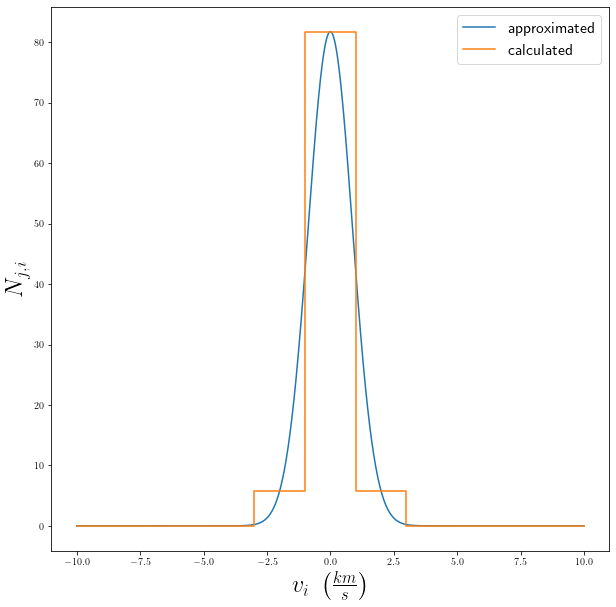

In [9]:
v_i = np.linspace(-10, 10, num=11)

plot_clump_number(v_i=v_i, n_v=None, suggested_fix=True)

         Integrated intensity (no discretisation): 37.752626636342065
       Integrated intensity (with discretisation): 36.965248597511525
Integrated intensity (fitted with discretisation): 36.965211558221384


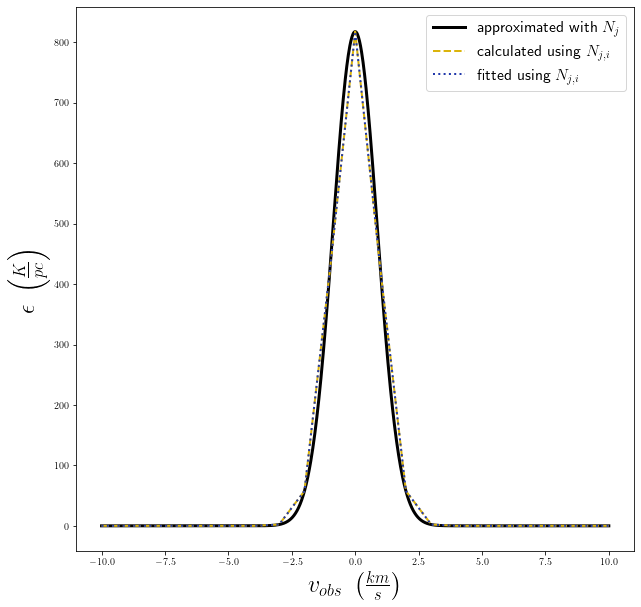

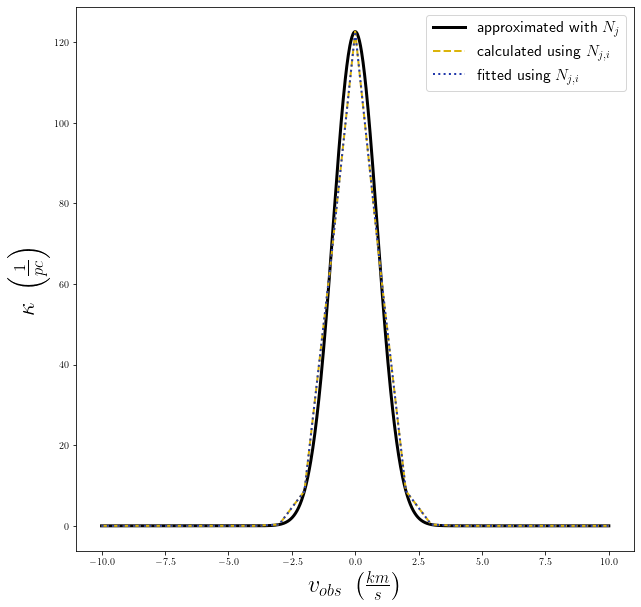

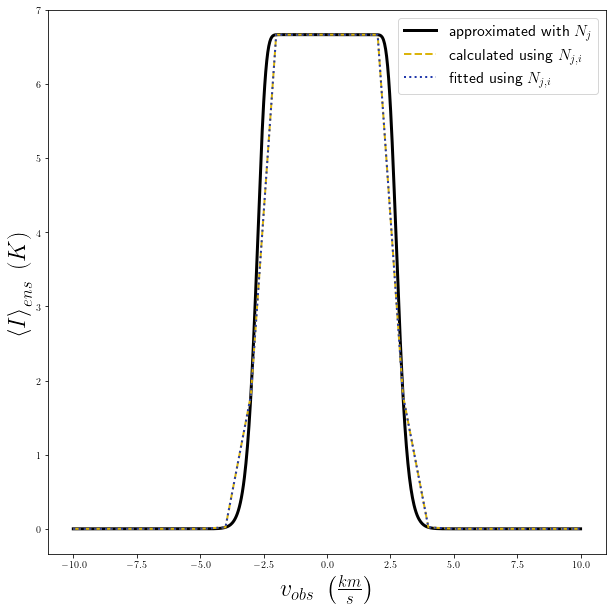

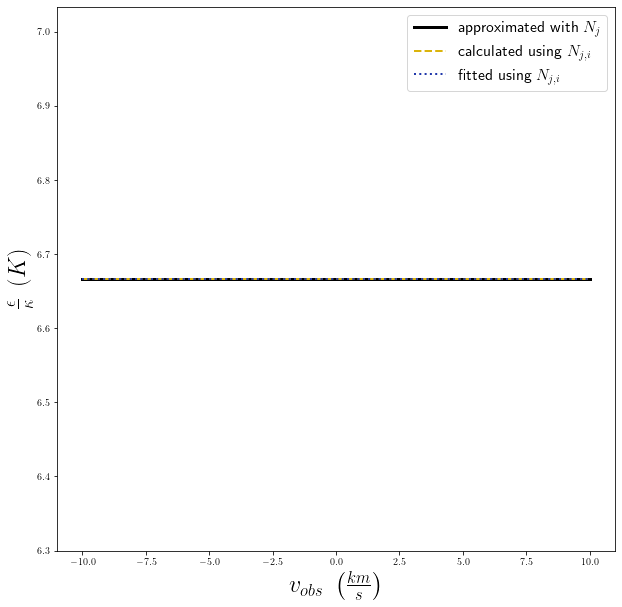

In [10]:
v_i = np.linspace(-10, 10, num=21)

plot_clumpy_emission(v_i=v_i, n_v=None, suggested_fix=True);

So this discretisation appears to be appropriate for estimating the overall structure of the emission.

### Using a finer discretisation

Now we may us the same functions, but this time we specify that internal velocity grid that should be evalvulated automatically with our given value of $n_{velocity}$.

(1, 500)
Total Mass (without discretisation): 100.000 M_sol
Total Mass (with discretisation): 100.000 M_sol


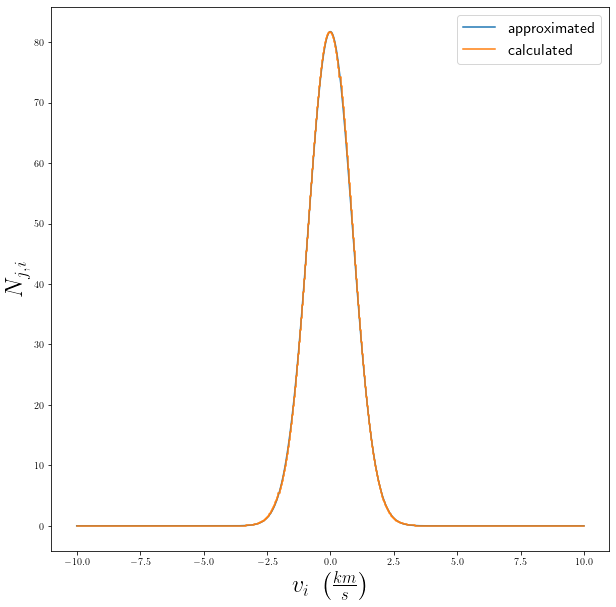

In [11]:
v_i = np.linspace(-10, 10, num=500)

plot_clump_number(v_i=v_i, suggested_fix=True)

         Integrated intensity (no discretisation): 37.752626636342065
       Integrated intensity (with discretisation): 37.75262663634207
Integrated intensity (fitted with discretisation): 37.75258880809676


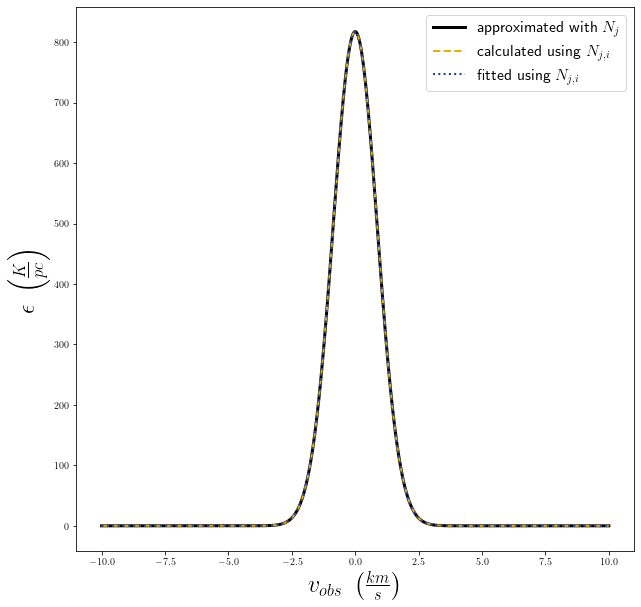

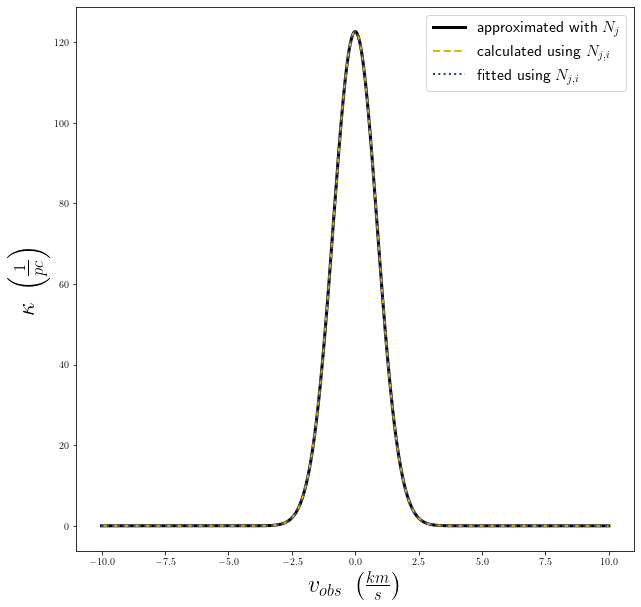

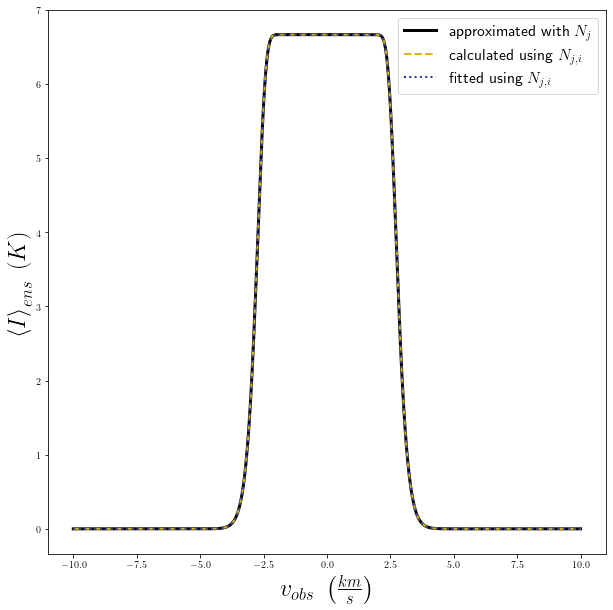

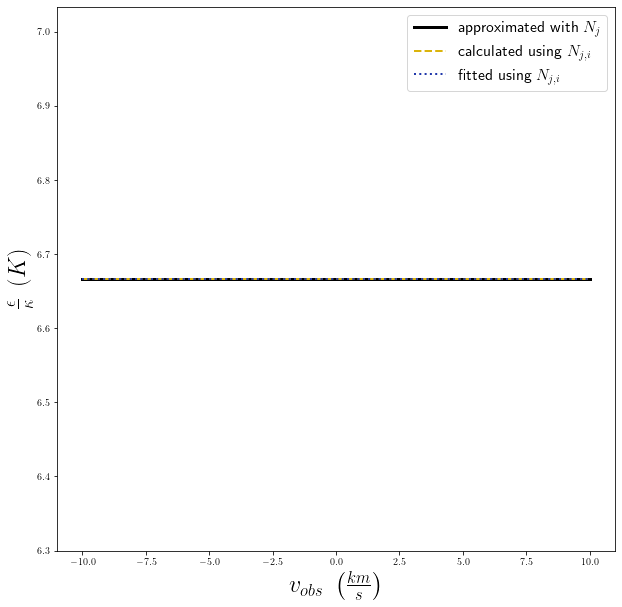

In [12]:
plot_clumpy_emission(v_i=v_i, suggested_fix=True);

Judging by the calculated $\varpi \equiv \int I dv$, this method performs with the same accuracy.

We also see that these approximations of the ensemble intensity both follow the same Gaussian distribution, since the factor of $\frac{\epsilon_{ens}}{\kappa_{ens}}$ is constant.

## Probabilistic approach

Thus-far we have merely considered how the discretisation affects the intensity of the ensemble. The full implementation of `kosmatau3d` uses a probabilistic approach to calculate the likelihood of having a given combination $k_{j,i}$ of clumps in your line-of-sight. The probability of each clump depends on its projected area ($\pi R_{cl}^2$) compared with the area of one face of the voxel ($\Delta s$).

$$
p_{j,i} = \binom{\Delta N_{j,i}}{k_{j,i}} \ p_j^{k_{j,i}} \ \left( 1 - p_j \right)^{\Delta N_{j,i} - k_{j,i}}
$$

This probability is then applied to the emissivity and opacity in different ways due to how they enter into the radiative transfer equation. For each systematic velocity,

$$
\begin{align}
\left< \epsilon \right>_{i} =& \sum_{k} \left( \prod_{j} p_{j,i} \right) \left( \sum_{j} k_{j,i} \epsilon_{j} \right) \ , \\
\left< \kappa \right>_{i} =& - \mathrm{log} \left[ \sum_{k} \left( \prod_{j} p_{j,i} \right) \mathrm{exp} \left( - \sum_{j} k_{j,i} \kappa_{j} \Delta s \right) \right] \ \div \ \Delta s \ .
\end{align}
$$

The voxel-averaged values are thus simply,

$$
\begin{align}
\left< \epsilon \right>_{vox} \left( v_{obs} \right) =& \sum_{i} \left< \epsilon \right>_{i} \left( v_{obs} \right) \ , \\
\left< \kappa \right>_{vox} \left( v_{obs} \right) =& \sum_{i} \left< \kappa \right>_{i} \left( v_{obs} \right) \ .
\end{align}
$$

In this manner the emissivity and opacity are decoupled and independant. There is an issue, though, since the sum over $v_i$ should occur before the probability of each combination is applied. Also, the probability should act on the intensity rather than the emissivity using $I_{\nu, i} = \frac{\epsilon_{\nu, i}}{\kappa_{\nu, i}} \bigg( 1 - exp \Big(- \kappa_{\nu, i} \Delta s \Big) \bigg)$. For these reasons the calculation should be corrected.

To avoid too many unnecessary loops, the suggestion is to calculate the clump number independant of $v_{i}$.

 > Assuming $\delta v_i << \sigma_{ens}$, then,
 >
 > $$
   \begin{align}
   \frac{dN_{j,i}}{dv_i} =& \ {\lim_{\delta v_i \to 0}} \left( \frac{\Delta N_{j,i}}{\delta v_i} \right) \ , \\
   =& \ \frac{N_j}{\sqrt{2 \pi \sigma_{ens}^2}} exp \Big( - \frac{(v_i-v_{vox})^2}{2 \sigma_{ens}^2} \Big) \ , \\
   =& \ \mathrm{constant}.
   \end{align}
   $$
 > 
 > Then for each observing velocity the sum over the contribution from each clump will be,
 > 
 > $$
   \begin{align}
   N_{j,i} =& \sum_i exp \Big( - \frac{(v_i-v_{obs})^2}{2\sigma_{cl}^2} \Big) \ \Delta N_{j,i} \ , \\
   =& \int_{-\inf}^\inf dv_i exp \Big( - \frac{(v_i-v_{obs})^2}{2\sigma_{cl}^2} \Big) \ \frac{dN_{j,i}}{dv_i} \ , \\
   =& \sqrt{2 \pi \sigma_{cl}^2} \ \frac{dN_{j,i}}{dv_i} \ , \\
   =& N_j \frac{\sigma_{cl}}{\sigma_{ens}} exp \Big( - \frac{(v_i-v_{vox})^2}{2 \sigma_{ens}^2} \Big) \ .
   \end{align}
   $$
 >
 > Since we are now including the contribution from clumps at other velocities in the definition of $N_{j,i}$, the velocity distribution of the ensemble is actually the total velocity dispersion $\sigma_{ens,eff}$. Below we examine the applicability of this assumption.

  Calculated curve area: 1.7797060749879714
Approximated curve area: 1.7797060749880098
      Formal curve area: 1.7797060749880105


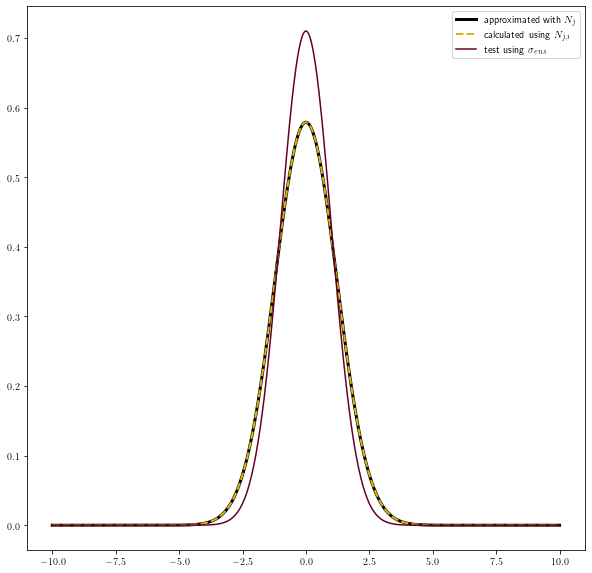

In [13]:
# Isolate the scope of this cell
def test_dist():
    
    # Define dispersion variables unique to this cell
    sigma_cl_test = copy(sigma_cl)
    sigma_ens_test = 1
    sigma_ens_eff_test = np.sqrt(sigma_ens_test**2 + sigma_cl**2)

    # Velocity arrays
    v_obs = np.linspace(-10, 10, num=1000)
    v_i = np.linspace(-10, 10, num=2001).reshape(-1, 1)
    dv_i = v_i[1]-v_i[0]

    # Calculate N_j,i using various approximations 
    y1 = (1/np.sqrt(2*np.pi*sigma_ens_test**2) * np.exp(-(v_i-0)**2/2/sigma_ens_test**2) * np.exp(-(v_i-v_obs.reshape(1, -1))**2/2/sigma_cl_test**2)).sum(0) * dv_i
    y2 = (np.sqrt(2*np.pi*sigma_cl_test**2)/np.sqrt(2*np.pi*sigma_ens_eff_test**2) * np.exp(-(0-v_obs)**2/2/sigma_ens_eff_test**2))
    mu_test = (sigma_ens_test**2*v_obs/(sigma_ens_test**2-sigma_cl_test**2)).reshape(1, -1)
    sigma_test = (sigma_ens_test**2*sigma_cl_test**2)/(sigma_ens_test**2+sigma_cl_test**2)
    # y3 = (1/np.sqrt(2*np.pi*sigma_test**2) * np.exp(-(v_i-mu_test)**2/(2*sigma_test**2))).sum(0) * dv_i
    y3 = (np.sqrt(2*np.pi*sigma_cl_test**2)/np.sqrt(2*np.pi*sigma_ens_test**2) * np.exp(-(v_obs-0)**2/(2*sigma_ens_test**2)))

    # Plot the approximations
    plt.figure(figsize=(10, 10))
    plt.plot(v_obs, y2, **approximated_kwargs)
    plt.plot(v_obs, y1, **calculated_kwargs)
    plt.plot(v_obs, y3, color="xkcd:maroon", label=r"test using $\sigma_{ens}$")
    plt.legend()
    
    # Print the area under each curve
    print("  Calculated curve area:", np.trapz(y1, v_obs))
    print("Approximated curve area:", np.trapz(y2, v_obs))
    print("      Formal curve area:", np.trapz(y3, v_obs))
    
    return

test_dist()

As seen above, the use of $\sigma_{ens_eff}$ fits better than $\sigma_{ens}$, though the area under each curve is the same.

## 

In [14]:
md(r'Now we wish to apply this procedure to our previous example. Let us assume our clump has a radius of $R_{cl} =$'
   + r'{} $pc$.'.format(r_j))

Now we wish to apply this procedure to our previous example. Let us assume our clump has a radius of $R_{cl} =$[0.5] $pc$.

### With a coarse discretisation

First we examine how the original discretisation handles a dense voxel.

/tmp/ipykernel_253304/4211362834.py:171: RuntimeWarning: invalid value encountered in true_divide
  intensity_comb = np.nan_to_num(eps_ens[i]/kap_ens[i]*ds * (1-np.exp(-kap_ens[i]*ds)))


         Integrated intensity (no discretisation): 36.894596046015096
       Integrated intensity (with discretisation): 26.599255921025055
Integrated intensity (fitted with discretisation): 26.599229268490717


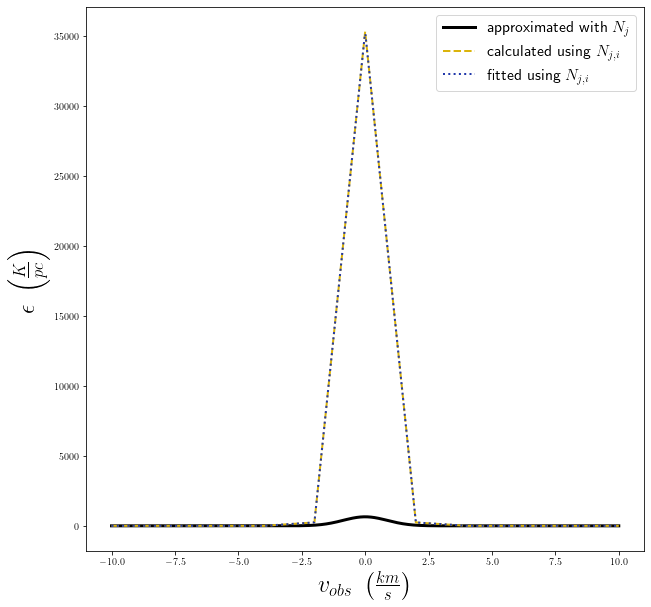

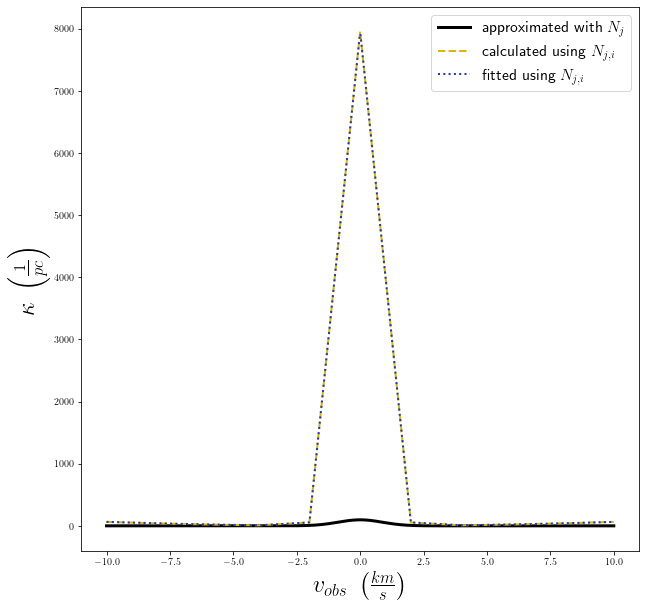

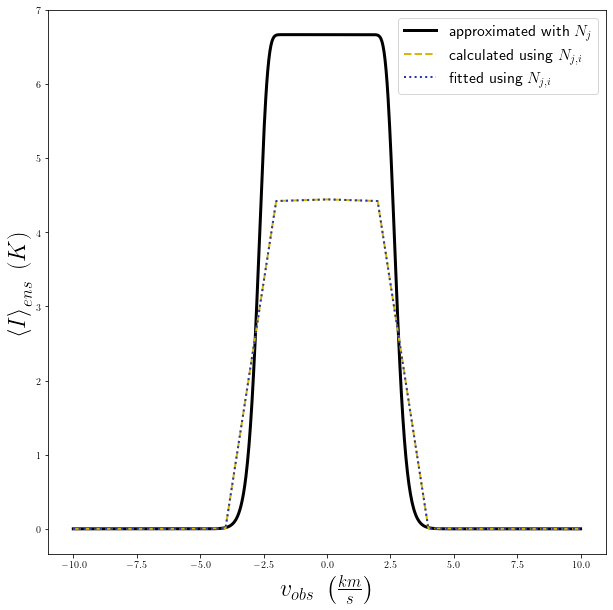

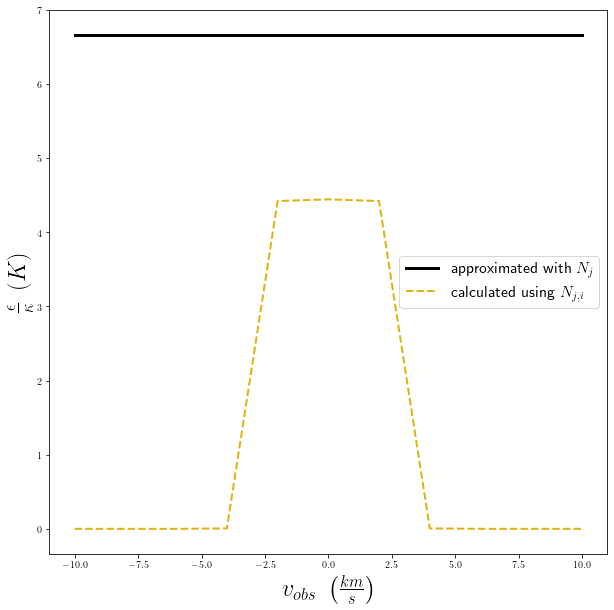

In [15]:
v_i = np.linspace(-10, 10, num=11)

plot_probabilistic_emission(v_i=v_i, n_v=None, suggested_fix=True) ;

[79]


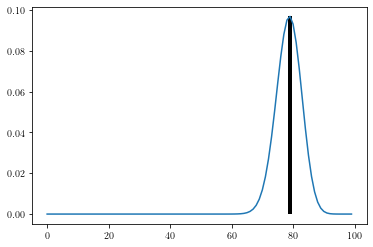

In [16]:
p_j = [np.pi*r**2/ds**2 for r in r_j]
x = [np.arange(0, n+1) for n in n_j]
x_mesh = np.asarray([comb.flatten() for comb in np.meshgrid(*x)])
y = [binom.pmf(x_mesh[j], n_j[j], p_j[j]) for j in range(len(n_j))]
prob = np.prod(y, axis=0)
i_max = prob.argmax()
n_ens = x_mesh[:, i_max]

plt.plot(prob[:100])
plt.vlines(i_max, 0, prob.max(), lw=4, color='xkcd:black')
print(n_ens)

As it can be seen, there are some wavy features on top of the absorption feature. So far as I can tell from the overall development of `kosmatau3d`, this is due to slight deviations of $\epsilon$ and $\kappa$ from a Gaussian distribution. The initial fraction in the radiative transfer equation, $\left( \frac{\epsilon}{\kappa} \right)$, should cancel out the Gaussian structure and equate to a constant. Now in the probabilistic discretisation, $\left< \epsilon \right>_{ens}$ and $\left< \kappa \right>_{ens}$ are not perfect Gaussians but follow a similar structure. For that reason we are mainly concerned with the smoothness of this initial fraction. When it has wavy features, the resulting intensity $\left< I \right>_{vox} \left( v_{obs} \right)$ will also have these wavy features.

Plots of this fraction can be seen below.

### Using a finer discretisation

Using a higher velocity resolution in the model should remove this wavy feature in the resulting $\left< I \right>_{vox} (v_{obs})$.

/tmp/ipykernel_253304/4211362834.py:171: RuntimeWarning: invalid value encountered in true_divide
  intensity_comb = np.nan_to_num(eps_ens[i]/kap_ens[i]*ds * (1-np.exp(-kap_ens[i]*ds)))


         Integrated intensity (no discretisation): 36.894596046015096
       Integrated intensity (with discretisation): 23.54677304742886
Integrated intensity (fitted with discretisation): 23.546749453491536


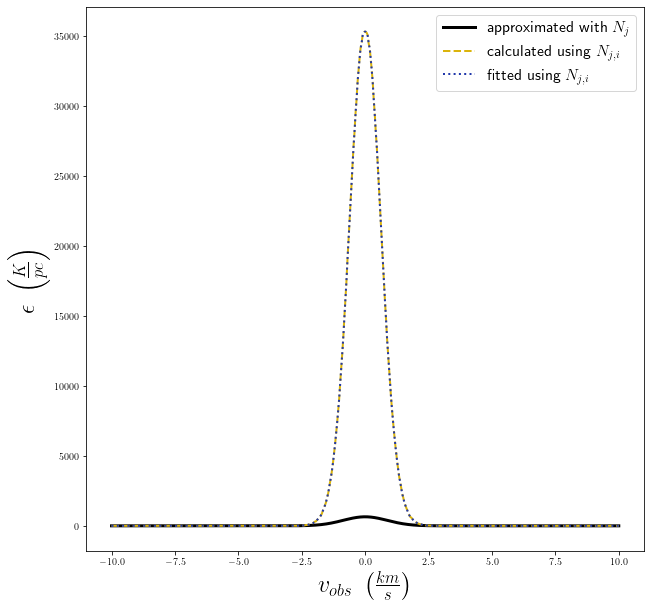

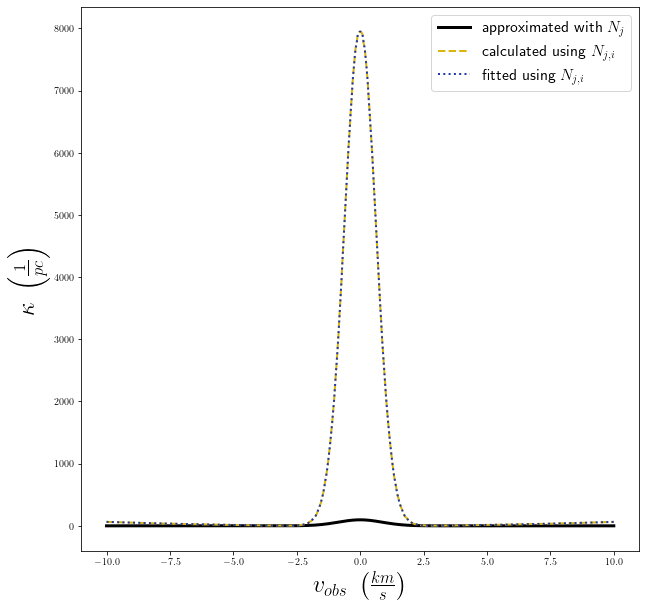

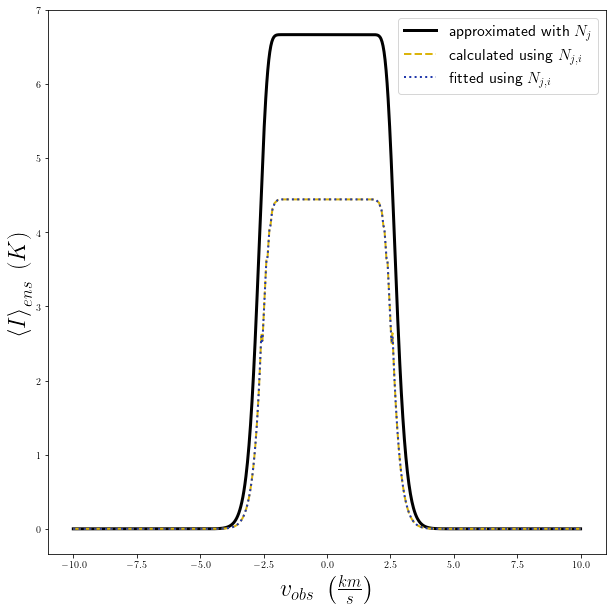

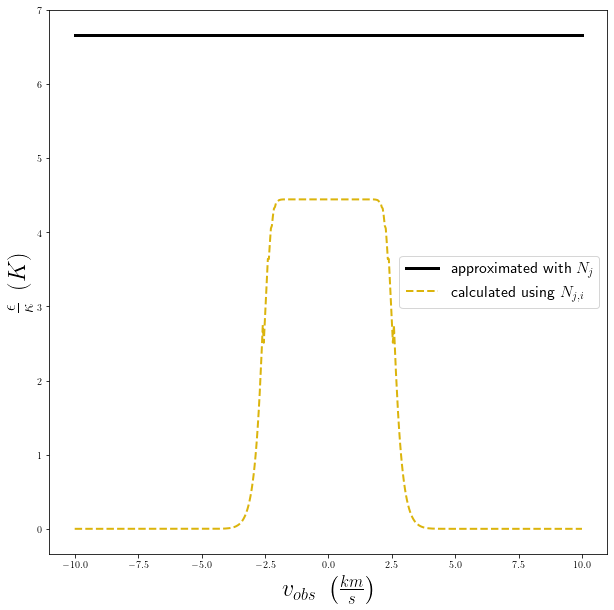

In [17]:
v_i = np.linspace(-10, 10, num=500)

plot_probabilistic_emission(v_i=v_i, n_v=None, suggested_fix=True) ;

[79]


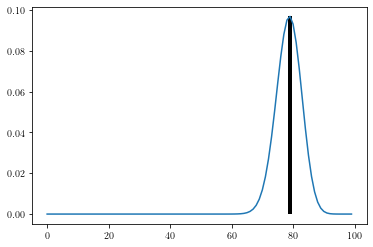

In [18]:
p_j = [np.pi*r**2/ds**2 for r in r_j]
x = [np.arange(0, n+1) for n in n_j]
x_mesh = np.asarray([comb.flatten() for comb in np.meshgrid(*x)])
y = [binom.pmf(x_mesh[j], n_j[j], p_j[j]) for j in range(len(n_j))]
prob = np.prod(y, axis=0)
i_max = prob.argmax()
n_ens = x_mesh[:, i_max]

plt.plot(prob[:100])
plt.vlines(i_max, 0, prob.max(), lw=4, color='xkcd:black')
print(n_ens)

There are still wavy features when `suggested_fix` is False, which is seen in .

This looks like the wavy features are no longer an issue when using `suggested_fix`. However, the factor used of $\frac{\left< \epsilon_\nu \right>_{vox}}{\left< \kappa_\nu \right>_{vox}}$ used to judge the validity of the discrete clump calculation will not work here, due to the use of $\left< \tau_\nu \right>_{vox}$ in deriving $\left< \epsilon_\nu \right>_{vox}$. Despite this, we can be sure of its validity due to the theoretical derivation and limiting of initial assumptions.

## 

When not using the suggested calculation, the previous plots not only show that a smooth fraction will result in a smooth absorption feature, but also that $\left< \epsilon \right>_{ens}$ and $\left< \kappa \right>_{ens}$ follow different distributions. To approximate this in terms of a Gaussian, we will perform a fit to examine how much they differ.

In [19]:
from scipy.optimize import curve_fit

def eps_eff(v, a, sigma_eff):
    return np.sum([a * n_ens[cl]*eps_j[cl]/np.sqrt(2*np.pi*sigma_eff**2) * np.exp(-v**2/2/sigma_eff**2) for cl in range(len(n_ens))], axis=0)

def kap_eff(v, a, sigma_eff):
    return np.sum([a * n_ens[cl]*kap_j[cl]/np.sqrt(2*np.pi*sigma_eff**2) * np.exp(-v**2/2/sigma_eff**2) for cl in range(len(n_ens))], axis=0)

In [20]:
# Only fit the emissivity and opacity when using the former calculation of the intensity
if not suggested_fix:
    
    def fit_emission():
    
        a_eps, sigma_eps_eff = curve_fit(eps_eff, v_obs, eps_ens, [1, sigma_ens])[0]
        a_kap, sigma_kap_eff = curve_fit(kap_eff, v_obs, kap_ens, [1, sigma_ens])[0]

        print('fitted amplitudes:\n{}\n{}\n'.format(a_eps, a_kap))
        print('fitted dispersions:\n{}\n{}\n'.format(sigma_eps_eff, sigma_kap_eff))

        eps_fit = eps_eff(v_obs, a_eps, sigma_eps_eff)
        kap_fit = kap_eff(v_obs, a_kap, sigma_kap_eff)

        # Emissivity
        plt.figure(figsize=figsize)
        plt.plot(v_obs, eps, c='xkcd:black', lw=3, label='approximated')
        plt.plot(v_obs, eps_fit, c='xkcd:charcoal', lw=2, ls='-', label='fitted')
        plt.plot(v_obs, eps_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
        plt.legend(fontsize=fontsize*legend_factor)
        plt.title('Fitted emissivity', fontsize=fontsize)
        plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        plt.ylabel(r'$\left< \epsilon \right>_{ens} \ \left( \frac{K}{pc} \right)$', fontsize=fontsize)
        
        # Opacity
        plt.figure(figsize=figsize)
        plt.plot(v_obs, kap, c='xkcd:black', lw=3, label='approximated')
        plt.plot(v_obs, kap_fit, c='xkcd:charcoal', lw=2, ls='-', label='fitted')
        plt.plot(v_obs, kap_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
        plt.legend(fontsize=fontsize*legend_factor)
        plt.title('Fitted opacity', fontsize=fontsize)
        plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        plt.ylabel(r'$\left< \kappa \right>_{ens} \ \left( \frac{1}{pc} \right)$', fontsize=fontsize)
        
        # Ratio
        plt.figure(figsize=figsize)
        plt.plot(v_obs, eps/kap, c='xkcd:black', lw=3, label='approximated')
        plt.plot(v_obs, eps_fit/kap_fit, 
                 c='xkcd:charcoal', lw=2, ls='-', label='fitted')
        plt.plot(v_obs, eps_ens/kap_ens, c='xkcd:vomit', lw=2, ls='--', label='calculated')
        plt.legend(fontsize=fontsize*legend_factor)
        plt.title('Fitted fraction', fontsize=fontsize)
        plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        plt.ylabel(r'$\frac{\left< \epsilon \right>_{ens}}{\left< \kappa \right>_{ens}} \ \left( K \right)$', fontsize=fontsize)
        
        # Intensity
        plt.figure(figsize=figsize)
        plt.plot(v_obs, eps/kap*(1-np.exp(-kap*ds)), c='xkcd:black', lw=3, label='approximated')
        plt.plot(v_obs, eps_fit/kap_fit*(1-np.exp(-kap_fit*ds)), c='xkcd:charcoal', lw=2, ls='-', label='fitted')
        plt.plot(v_obs, eps_ens/kap_ens*(1-np.exp(-kap_ens*ds)), c='xkcd:vomit', lw=2, ls='--', label='calculated')
        plt.legend(fontsize=fontsize*legend_factor)
        plt.title('Fitted Intensity', fontsize=fontsize)
        plt.xlabel(r'$v_{obs} \ \left( \frac{km}{s} \right)$', fontsize=fontsize)
        plt.ylabel(r'$\left< I \right>_{ens} \ \left( K \right)$', fontsize=fontsize)
        
        return
    
    fit_emission()

## 

## Final remarks

It is clear that the probabilistic approach affects the behaviour of the emissivity and opacity with respect to observing velocity. Using a standard assumption that both the emissivity and the absorption follow the same Gaussian distribution with velocity dispersion $\sigma_{ens, eff}$, their ratio will cause the Gaussian distributions to cancel and the result will be a value constant with respect to observing velocity. If we assume the emissivity and opacity follow two slightly different Gaussians (as in the fitted values), then the ratio will also have a Gaussian structure. What seems to be happening in the probabilistic approach is that the voxel-averaged emissivity follows a more strongly-peaked Gaussian than the voxel-averaged opacity near the center velocity, whereas they follow the same Gaussian distribution far away from the center velocity. The pseudo-Gaussian behaviour of these values appear to cause the steep edges in the wings of the intensity plot. The fitted emissivity and opacity are very close to the voxel-averaged values, but they are unable to capture these sharp wings.

In the end, we have to decide what how the model should work. If we just want the single-voxel model to model the emissivity and opacity as simple Gaussians, then much of the complexity in `kosmatau3d` can be removed. Personally, I think that one of the advantages in the probabilistic clumpy distribution is that it is more complex than a simple Gaussian. Therefore, if there is insufficient reason to alter this approach, I am in favour of keeping the complexity of the probabilistic approach (even if it is computationally demanding).

Another implementation suggestion is to remove the internal velocity grid entirely and use a modified $\sigma_{ens}$ in the exponent (as attempted in the fitting function) when calculating the number of clumps. It is sufficiently shown above that approximating the clumps in a line-of-sight by finding the most-probable combination works suitably-well for approximating the intensity of the voxel. While this does not suffer from the discretisation artefacts of the internal velocity grid and is much more computationally-efficient, it needs to be much more clearly shown that this method works for all possible combinations. There is also a slight issue regarding low clump numbers...

In conclusion, the voxel intensity calculation should be restructured to adopt a more-efficient method. This will also help reduce the immense complexity of the code (particularily in the `ensemble` submodule) and decrease computation time.